- Uncomment the following lines when you use a Kaggle notebook.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-stock-prediction/news_processed_filtered_2.csv
/kaggle/input/netflix-stock-prediction/test.csv
/kaggle/input/netflix-stock-prediction/netflix_60.csv


In [2]:
import pandas as pd
import numpy as np
# import category_encoders as ce
# import copy
# import polars as pl

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
# import plotly.express as px
# %matplotlib inline
# matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# CatBoost
# from catboost import CatBoostRegressor

# PyTorch
import torch
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error
import sklearn

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations,product
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

### Basic settings
pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

### Setting universal random_state
np.random.seed(142)
random.seed(142)
sklearn.utils.check_random_state(142)
torch.manual_seed(142)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cpu


In [3]:
### Class for preparing datasets
class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df

### When you use local directory
stock_filepath = '../../data/stock_price/netflix_60.csv' 
news_filepath = '../../data/scraping/news_processed_filtered.csv'
testfile = '../../data/test.csv'

### When you use Colab
# stock_filepath = './drive/MyDrive/Colab Notebooks/data/netflix_60.csv'
# news_filepath = './drive/MyDrive/Colab Notebooks/data/news_processed_filtered.csv'
# testfile = './drive/MyDrive/Colab Notebooks/data/test.csv'

### When you use Kaggle Notebook
# stock_filepath = '/kaggle/input/netflix-stock-prediction/netflix_60.csv'
# news_filepath = '/kaggle/input/netflix-stock-prediction/news_processed_filtered.csv'
# testfile = '/kaggle/input/netflix-stock-prediction/test.csv'

loader = PrepareData(stock_filepath, news_filepath)
stock_df, news_df=loader.load_data() 
total_df = loader.merging(stock=stock_df, news=news_df) 
test_df = pd.read_csv(testfile)

### fill nan in 'PINS' column
stock_df.index = stock_df["Date"]
stock_df.drop(columns = "Date", inplace = True)
stock_df["PINS"].fillna(24.99, inplace = True)
total_df.index = total_df["Date"]
total_df.drop(columns = "Date", inplace = True)
total_df["PINS"].fillna(24.99, inplace = True)

# Set Parameters
- datanames = 'total_df' / 'stock_df'
- MODEL = 'Transformer'
- TARGET = "Close" / "1d_ROC"
- SEQ_SIZE = 30 / 60 / 120
- BATCH_SIZE = 1 / 4 / 8
- HIDDEN_SIZE = 64 / 128
- N_TRIALS = as much as you want

### Transformer model reference
- https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb

In [5]:
best_losses = []
mean_error_ratios = []

### Set Parameters
datanames = 'total_df'         # ['total_df','stock_df']
MODEL = 'Transformer'          # 'LSTM' / 'GRU' / 'Transformer'
TARGET = "1d_ROC"              # "Close" / "1d_ROC"
SEQ_SIZE = 30                  # 30 / 60 / 120
PRED_SIZE = 10
BATCH_SIZE = 1                 # 1 / 4 / 8
HIDDEN_SIZE = 64               # 64 / 128
EPOCHS = 1000
N_TRIALS = 50                  # 10 / 50 / 100

if dataname=='total_df':
    data = total_df
else:
    data = stock_df


filename = f'{MODEL}_{dataname}_{TARGET}_seq{SEQ_SIZE}_batch{BATCH_SIZE}_hidden{HIDDEN_SIZE}_{N_TRIALS}trials'

print(f'🔸START - {filename}🔸')
### Make train datset

def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, :]  # Adjusted for Pandas
        tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
        x.append(tmp_x.values)  # Convert to numpy array
        y.append(tmp_y.values)  # Convert to numpy array

    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)

### Define X_test
X_test = data.tail(SEQ_SIZE).values.reshape(1, SEQ_SIZE, data.shape[1])

### Standardization
from sklearn.preprocessing import StandardScaler

X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = X.reshape(X.shape[0], SEQ_SIZE, data.shape[1])

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_test = scaler.transform(X_test)
X_test = X_test.reshape(X_test.shape[0], SEQ_SIZE, data.shape[1])

### Split train-validation dataset
# to DataLoader
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

for trial in tqdm(list(range(1,N_TRIALS+1))):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1, test_size = 0.2)

    # to tensor
    X_train = torch.tensor(X_train.astype(np.float32), dtype = torch.float32)
    X_valid = torch.tensor(X_valid.astype(np.float32), dtype = torch.float32)
    y_train = torch.tensor(y_train.astype(np.float32), dtype = torch.float32)
    y_valid = torch.tensor(y_valid.astype(np.float32), dtype = torch.float32)

    # to DataLoader
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = BATCH_SIZE, shuffle = True)
    val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size = BATCH_SIZE, shuffle = False)

    ### Initialize Model
    try:
        for param in model.parameters():
            if param.requires_grad:
                if len(param.shape) > 1:
                    init.xavier_uniform_(param)
                else:
                    init.zeros_(param)
    except:
        try:
            model.reset_parameters()
        except:
            pass

    ### Modeling
    import copy
    class EarlyStopping:
        def __init__(self, patience = 5, min_delta = 0, restore_best_weights = True):
            self.patience = patience
            self.min_delta = min_delta
            self.restore_best_weights = restore_best_weights
            self.best_model = None
            self.best_loss = None
            self.counter = 0
            self.status = ""

        def __call__(self, model, val_loss):
            if self.best_loss is None:
                self.best_loss = val_loss
                self.best_model = copy.deepcopy(model.state_dict())
            elif self.best_loss - val_loss >= self.min_delta:
                self.best_model = copy.deepcopy(model.state_dict())
                self.best_loss = val_loss
                self.counter = 0
                self.status = f"Improvement found, counter reset to {self.counter}"
            else:
                self.counter += 1
                self.status = f"No improvement in the last {self.counter} epochs"
                if self.counter >= self.patience:
                    self.status = f"Early stopping triggered after {self.counter} epochs."
                    if self.restore_best_weights:
                        model.load_state_dict(self.best_model)
                    return True
            return False

    # Positional Encoding for Transformer
    class PositionalEncoding(nn.Module):
        def __init__(self, d_model, dropout=0.1, max_len=2000):
            super(PositionalEncoding, self).__init__()
            self.dropout = nn.Dropout(p=dropout)

            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0).transpose(0, 1)
            self.register_buffer('pe', pe)

        def forward(self, x):
            x = x + self.pe[:x.size(0), :]
            return self.dropout(x)

    # Model definition using Transformer
    class TransformerModel(nn.Module):
        def __init__(self, input_dim, d_model, nhead=4, num_layers=2, dropout=0.2, output_size=10):
            super(TransformerModel, self).__init__()

            self.encoder = nn.Linear(input_dim, d_model,bias=True)
            self.pos_encoder = PositionalEncoding(d_model, dropout)
            encoder_layers = nn.TransformerEncoderLayer(d_model, nhead,bias=True)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
            self.decoder = nn.Linear(d_model, output_size,bias=True)

        def forward(self, x):
            x = self.encoder(x)
            x = self.pos_encoder(x)
            x = self.transformer_encoder(x)
            x = self.decoder(x[:, -1, :])
            return x

    class RMSELoss(nn.Module):
        def __init__(self):
            super(RMSELoss,self).__init__()
            self.mse = nn.MSELoss()

        def forward(self,yhat,y):
            return torch.sqrt(self.mse(yhat,y))

    globals()[f'model{trial}'] = TransformerModel(X_train.shape[2],
                                d_model = HIDDEN_SIZE,
                                output_size = PRED_SIZE).to(device)criterion = RMSELoss()
    optimizer = optim.Adam(globals()[f'model{trial}'].parameters(), lr = 0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 20, verbose = True)

    ### RUN!!

    epoch_counter = 0
    patience = 30
    best_loss = float('inf')
    done = False
    es = EarlyStopping(patience=patience)
    tr_losses_fp, val_losses_fp = [],[]

    while not done and epoch_counter<EPOCHS:
        epoch_counter+=1

        # train
        globals()[f'model{trial}'].train()
        train_losses = []
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = globals()[f'model{trial}'](x_batch)
            loss = criterion(output,y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        tr_losses_fp.append(train_loss)

        # validation
        globals()[f'model{trial}'].eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                output = globals()[f'model{trial}'](x_batch)
                loss = criterion(output, y_batch)
                val_losses.append(loss.item())
        val_loss = np.mean(val_losses)
        val_losses_fp.append(val_loss)
        scheduler.step(val_loss)

        if es(globals()[f'model{trial}'], val_loss):
            done = True

        if val_loss < best_loss:
            best_loss = val_loss

        if epoch_counter%20 == 0:
            print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    print(f"Best validation loss : {best_loss}")
    best_losses.append(best_loss)

    globals()[f'train_losses_{trial}']=tr_losses_fp
    globals()[f'val_losses_{trial}']=val_losses_fp

    ### Prediction
    # evaluation
    globals()[f'model{trial}'].eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.astype(np.float32), dtype = torch.float32,device=device)
        pred = globals()[f'model{trial}'](X_test_tensor)

    pred = pred.to('cpu').detach().numpy()

    if TARGET == "1d_ROC" :
        endPrice = data['Close'].iloc[-1]
        pred_close = []

        for i in pred[0] :
            endPrice = endPrice + endPrice*0.01*i
            pred_close.append(endPrice)

        pred = np.array(pred_close).reshape(1, PRED_SIZE)
    else :
        pass

    globals()[f'pred_{trial}'] = pred

    ### Evaluation
    # Label
    label = test_df.copy()
    label = np.array(label.head(PRED_SIZE)["Close Price"])

    # Prediction
    pred = np.array(pred).reshape(PRED_SIZE)

    # 날짜 데이터
    period = test_df["Date"].copy()
    period = [d for d in period.head(PRED_SIZE)]

    # 오차율 계산
    error_rate = np.abs((label - pred) / label) * 100

    # 평균 오차율 계산
    average_error_rate = np.mean(error_rate)

    print(f"Average Error Rate: {average_error_rate:.2f}%")
    mean_error_ratios.append(average_error_rate)

print('🔸END🔸')

🔸START - LSTM_total_df_1d_ROC_seq120_batch1_hidden64🔸


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/1000, Train Loss: 2.4658, Validation Loss: 2.4354
Epoch 40/1000, Train Loss: 2.3360, Validation Loss: 2.3609
Epoch 60/1000, Train Loss: 2.2509, Validation Loss: 2.3176
Epoch 80/1000, Train Loss: 2.1743, Validation Loss: 2.3231
Epoch 00096: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0634, Validation Loss: 2.3361


  2%|▏         | 1/50 [09:38<7:52:06, 578.09s/it]

Best validation loss : 2.3010590445678845
Average Error Rate: 1.71%
Epoch 20/1000, Train Loss: 2.4460, Validation Loss: 2.4318
Epoch 40/1000, Train Loss: 2.3264, Validation Loss: 2.3523
Epoch 60/1000, Train Loss: 2.2477, Validation Loss: 2.3263
Epoch 80/1000, Train Loss: 2.1632, Validation Loss: 2.3323
Epoch 00095: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0431, Validation Loss: 2.3096


  4%|▍         | 2/50 [19:08<7:38:55, 573.66s/it]

Best validation loss : 2.294899584972753
Average Error Rate: 1.49%
Epoch 20/1000, Train Loss: 2.4639, Validation Loss: 2.4358
Epoch 40/1000, Train Loss: 2.3436, Validation Loss: 2.3666
Epoch 60/1000, Train Loss: 2.2659, Validation Loss: 2.3452
Epoch 80/1000, Train Loss: 2.2075, Validation Loss: 2.3364
Epoch 00086: reducing learning rate of group 0 to 1.0000e-04.


  6%|▌         | 3/50 [27:56<7:13:00, 552.77s/it]

Best validation loss : 2.3081311886816955
Average Error Rate: 2.42%
Epoch 20/1000, Train Loss: 2.4335, Validation Loss: 2.4041
Epoch 40/1000, Train Loss: 2.3332, Validation Loss: 2.3379
Epoch 60/1000, Train Loss: 2.2433, Validation Loss: 2.2872
Epoch 80/1000, Train Loss: 2.1659, Validation Loss: 2.3111
Epoch 00084: reducing learning rate of group 0 to 1.0000e-04.


  8%|▊         | 4/50 [36:30<6:51:58, 537.36s/it]

Best validation loss : 2.277395541689037
Average Error Rate: 1.88%
Epoch 20/1000, Train Loss: 2.4696, Validation Loss: 2.4265
Epoch 40/1000, Train Loss: 2.3240, Validation Loss: 2.3565
Epoch 60/1000, Train Loss: 2.2269, Validation Loss: 2.3501
Epoch 80/1000, Train Loss: 2.1686, Validation Loss: 2.3441
Epoch 100/1000, Train Loss: 2.0880, Validation Loss: 2.3929
Epoch 00109: reducing learning rate of group 0 to 1.0000e-04.


 10%|█         | 5/50 [47:22<7:14:03, 578.75s/it]

Best validation loss : 2.3207440339358505
Average Error Rate: 3.20%
Epoch 20/1000, Train Loss: 2.4647, Validation Loss: 2.4230
Epoch 40/1000, Train Loss: 2.3411, Validation Loss: 2.3486
Epoch 60/1000, Train Loss: 2.2788, Validation Loss: 2.3536
Epoch 80/1000, Train Loss: 2.2180, Validation Loss: 2.3571
Epoch 00087: reducing learning rate of group 0 to 1.0000e-04.


 12%|█▏        | 6/50 [56:10<6:51:51, 561.61s/it]

Best validation loss : 2.324164463619215
Average Error Rate: 2.45%
Epoch 20/1000, Train Loss: 2.4650, Validation Loss: 2.4302
Epoch 40/1000, Train Loss: 2.3483, Validation Loss: 2.3489
Epoch 60/1000, Train Loss: 2.2594, Validation Loss: 2.3089
Epoch 80/1000, Train Loss: 2.1892, Validation Loss: 2.3325
Epoch 00088: reducing learning rate of group 0 to 1.0000e-04.


 14%|█▍        | 7/50 [1:05:14<6:38:21, 555.84s/it]

Best validation loss : 2.296550249103951
Average Error Rate: 1.89%
Epoch 20/1000, Train Loss: 2.4645, Validation Loss: 2.4378
Epoch 40/1000, Train Loss: 2.3599, Validation Loss: 2.3781
Epoch 60/1000, Train Loss: 2.2878, Validation Loss: 2.3175
Epoch 80/1000, Train Loss: 2.2159, Validation Loss: 2.3372
Epoch 00081: reducing learning rate of group 0 to 1.0000e-04.


 16%|█▌        | 8/50 [1:14:49<6:33:20, 561.92s/it]

Best validation loss : 2.317528729417683
Average Error Rate: 1.99%
Epoch 20/1000, Train Loss: 2.4493, Validation Loss: 2.4125
Epoch 40/1000, Train Loss: 2.3121, Validation Loss: 2.3462
Epoch 60/1000, Train Loss: 2.2515, Validation Loss: 2.3487
Epoch 80/1000, Train Loss: 2.1712, Validation Loss: 2.3471
Epoch 00088: reducing learning rate of group 0 to 1.0000e-04.


 18%|█▊        | 9/50 [1:24:58<6:33:54, 576.45s/it]

Best validation loss : 2.303287603686341
Average Error Rate: 1.69%
Epoch 20/1000, Train Loss: 2.3865, Validation Loss: 2.3557
Epoch 40/1000, Train Loss: 2.3136, Validation Loss: 2.3541
Epoch 60/1000, Train Loss: 2.2210, Validation Loss: 2.3308
Epoch 00068: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.1061, Validation Loss: 2.2961
Epoch 100/1000, Train Loss: 2.0756, Validation Loss: 2.2976
Epoch 00115: reducing learning rate of group 0 to 1.0000e-05.
Epoch 120/1000, Train Loss: 2.0565, Validation Loss: 2.2979


 20%|██        | 10/50 [1:37:19<6:58:14, 627.35s/it]

Best validation loss : 2.2914648662626216
Average Error Rate: 4.48%
Epoch 20/1000, Train Loss: 2.4612, Validation Loss: 2.4312
Epoch 40/1000, Train Loss: 2.3434, Validation Loss: 2.3544
Epoch 60/1000, Train Loss: 2.2925, Validation Loss: 2.3447
Epoch 80/1000, Train Loss: 2.2413, Validation Loss: 2.3765
Epoch 00086: reducing learning rate of group 0 to 1.0000e-04.


 22%|██▏       | 11/50 [1:46:10<6:28:42, 598.01s/it]

Best validation loss : 2.3416495505159935
Average Error Rate: 2.81%
Epoch 20/1000, Train Loss: 2.4354, Validation Loss: 2.4142
Epoch 40/1000, Train Loss: 2.3241, Validation Loss: 2.3360
Epoch 60/1000, Train Loss: 2.2274, Validation Loss: 2.3149
Epoch 80/1000, Train Loss: 2.1656, Validation Loss: 2.3292
Epoch 00087: reducing learning rate of group 0 to 1.0000e-04.


 24%|██▍       | 12/50 [1:55:09<6:07:19, 580.00s/it]

Best validation loss : 2.304629064239232
Average Error Rate: 1.27%
Epoch 20/1000, Train Loss: 2.4634, Validation Loss: 2.4275
Epoch 40/1000, Train Loss: 2.3373, Validation Loss: 2.3511
Epoch 60/1000, Train Loss: 2.2603, Validation Loss: 2.3212
Epoch 80/1000, Train Loss: 2.1898, Validation Loss: 2.3722
Epoch 00083: reducing learning rate of group 0 to 1.0000e-04.


 26%|██▌       | 13/50 [2:04:31<5:54:12, 574.40s/it]

Best validation loss : 2.3141227612453226
Average Error Rate: 1.38%
Epoch 20/1000, Train Loss: 2.4572, Validation Loss: 2.4322
Epoch 40/1000, Train Loss: 2.3309, Validation Loss: 2.3431
Epoch 60/1000, Train Loss: 2.2620, Validation Loss: 2.3476
Epoch 80/1000, Train Loss: 2.1811, Validation Loss: 2.3441
Epoch 100/1000, Train Loss: 2.1194, Validation Loss: 2.3205
Epoch 00116: reducing learning rate of group 0 to 1.0000e-04.
Epoch 120/1000, Train Loss: 1.9917, Validation Loss: 2.3235


 28%|██▊       | 14/50 [2:19:31<6:43:41, 672.81s/it]

Best validation loss : 2.293303478608089
Average Error Rate: 1.85%
Epoch 20/1000, Train Loss: 2.4337, Validation Loss: 2.3969
Epoch 40/1000, Train Loss: 2.3297, Validation Loss: 2.3457
Epoch 60/1000, Train Loss: 2.2417, Validation Loss: 2.3068
Epoch 80/1000, Train Loss: 2.1806, Validation Loss: 2.3168
Epoch 00089: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0602, Validation Loss: 2.2919
Epoch 00119: reducing learning rate of group 0 to 1.0000e-05.
Epoch 120/1000, Train Loss: 2.0306, Validation Loss: 2.2911
Epoch 00140: reducing learning rate of group 0 to 1.0000e-06.
Epoch 140/1000, Train Loss: 2.0225, Validation Loss: 2.2921


 30%|███       | 15/50 [2:35:44<7:25:16, 763.33s/it]

Best validation loss : 2.2877025118971295
Average Error Rate: 1.29%
Epoch 20/1000, Train Loss: 2.4513, Validation Loss: 2.4219
Epoch 40/1000, Train Loss: 2.3217, Validation Loss: 2.3522
Epoch 60/1000, Train Loss: 2.2643, Validation Loss: 2.3662
Epoch 00072: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.1372, Validation Loss: 2.3292


 32%|███▏      | 16/50 [2:44:48<6:35:08, 697.30s/it]

Best validation loss : 2.3248801373802457
Average Error Rate: 1.29%
Epoch 20/1000, Train Loss: 2.4632, Validation Loss: 2.4303
Epoch 40/1000, Train Loss: 2.3336, Validation Loss: 2.3589
Epoch 60/1000, Train Loss: 2.2500, Validation Loss: 2.3517
Epoch 80/1000, Train Loss: 2.2032, Validation Loss: 2.3605
Epoch 00086: reducing learning rate of group 0 to 1.0000e-04.


 34%|███▍      | 17/50 [2:54:53<6:08:10, 669.41s/it]

Best validation loss : 2.3305227010123497
Average Error Rate: 1.32%
Epoch 20/1000, Train Loss: 2.4396, Validation Loss: 2.4130
Epoch 40/1000, Train Loss: 2.3235, Validation Loss: 2.3664
Epoch 60/1000, Train Loss: 2.2618, Validation Loss: 2.3811
Epoch 00068: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.1574, Validation Loss: 2.3615


 36%|███▌      | 18/50 [3:04:07<5:38:35, 634.86s/it]

Best validation loss : 2.348036739414772
Average Error Rate: 2.40%
Epoch 20/1000, Train Loss: 2.4507, Validation Loss: 2.4187
Epoch 40/1000, Train Loss: 2.3367, Validation Loss: 2.3522
Epoch 60/1000, Train Loss: 2.2634, Validation Loss: 2.3302
Epoch 80/1000, Train Loss: 2.2155, Validation Loss: 2.3383
Epoch 100/1000, Train Loss: 2.1450, Validation Loss: 2.3047
Epoch 00118: reducing learning rate of group 0 to 1.0000e-04.
Epoch 120/1000, Train Loss: 2.0408, Validation Loss: 2.2752
Epoch 00140: reducing learning rate of group 0 to 1.0000e-05.
Epoch 140/1000, Train Loss: 1.9942, Validation Loss: 2.2918


 38%|███▊      | 19/50 [3:20:04<6:18:00, 731.62s/it]

Best validation loss : 2.273347794482138
Average Error Rate: 3.14%
Epoch 20/1000, Train Loss: 2.4712, Validation Loss: 2.4228
Epoch 40/1000, Train Loss: 2.4145, Validation Loss: 2.3943
Epoch 60/1000, Train Loss: 2.3074, Validation Loss: 2.3725
Epoch 80/1000, Train Loss: 2.2528, Validation Loss: 2.3832
Epoch 100/1000, Train Loss: 2.1746, Validation Loss: 2.3627
Epoch 00118: reducing learning rate of group 0 to 1.0000e-04.
Epoch 120/1000, Train Loss: 2.0664, Validation Loss: 2.3440


 40%|████      | 20/50 [3:33:25<6:16:12, 752.43s/it]

Best validation loss : 2.3265776019708246
Average Error Rate: 1.67%
Epoch 20/1000, Train Loss: 2.4543, Validation Loss: 2.4258
Epoch 40/1000, Train Loss: 2.3327, Validation Loss: 2.3462
Epoch 60/1000, Train Loss: 2.2466, Validation Loss: 2.3283
Epoch 00070: reducing learning rate of group 0 to 1.0000e-04.


 42%|████▏     | 21/50 [3:41:53<5:28:11, 679.03s/it]

Epoch 80/1000, Train Loss: 2.1408, Validation Loss: 2.3292
Best validation loss : 2.321402068422959
Average Error Rate: 2.41%
Epoch 20/1000, Train Loss: 2.4250, Validation Loss: 2.3863
Epoch 40/1000, Train Loss: 2.3254, Validation Loss: 2.3629
Epoch 60/1000, Train Loss: 2.2542, Validation Loss: 2.3376
Epoch 80/1000, Train Loss: 2.1981, Validation Loss: 2.3449
Epoch 00094: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0712, Validation Loss: 2.3352


 44%|████▍     | 22/50 [3:52:45<5:13:09, 671.07s/it]

Best validation loss : 2.313290510293657
Average Error Rate: 5.08%
Epoch 20/1000, Train Loss: 2.4626, Validation Loss: 2.4354
Epoch 40/1000, Train Loss: 2.3473, Validation Loss: 2.3693
Epoch 60/1000, Train Loss: 2.2786, Validation Loss: 2.3444
Epoch 80/1000, Train Loss: 2.1992, Validation Loss: 2.3536
Epoch 00095: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0487, Validation Loss: 2.3468


 46%|████▌     | 23/50 [4:03:41<4:59:51, 666.34s/it]

Best validation loss : 2.326701808292254
Average Error Rate: 1.95%
Epoch 20/1000, Train Loss: 2.4583, Validation Loss: 2.4398
Epoch 40/1000, Train Loss: 2.3296, Validation Loss: 2.3415
Epoch 60/1000, Train Loss: 2.2681, Validation Loss: 2.3370
Epoch 80/1000, Train Loss: 2.2092, Validation Loss: 2.3443
Epoch 00086: reducing learning rate of group 0 to 1.0000e-04.


 48%|████▊     | 24/50 [4:14:14<4:44:29, 656.52s/it]

Best validation loss : 2.321975667392258
Average Error Rate: 1.73%
Epoch 20/1000, Train Loss: 2.4661, Validation Loss: 2.4295
Epoch 40/1000, Train Loss: 2.3480, Validation Loss: 2.3505
Epoch 60/1000, Train Loss: 2.2773, Validation Loss: 2.3311
Epoch 00075: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.1744, Validation Loss: 2.3186
Epoch 100/1000, Train Loss: 2.1432, Validation Loss: 2.3185
Epoch 00104: reducing learning rate of group 0 to 1.0000e-05.


 50%|█████     | 25/50 [4:26:46<4:45:24, 684.99s/it]

Best validation loss : 2.3134339673329243
Average Error Rate: 1.30%
Epoch 20/1000, Train Loss: 2.4692, Validation Loss: 2.4309
Epoch 40/1000, Train Loss: 2.3502, Validation Loss: 2.3569
Epoch 60/1000, Train Loss: 2.3005, Validation Loss: 2.3695
Epoch 00069: reducing learning rate of group 0 to 1.0000e-04.


 52%|█████▏    | 26/50 [4:35:04<4:11:37, 629.06s/it]

Best validation loss : 2.3477999185566354
Average Error Rate: 2.56%
Epoch 20/1000, Train Loss: 2.4699, Validation Loss: 2.4323
Epoch 40/1000, Train Loss: 2.3544, Validation Loss: 2.3656
Epoch 60/1000, Train Loss: 2.2904, Validation Loss: 2.3564
Epoch 80/1000, Train Loss: 2.2264, Validation Loss: 2.3318
Epoch 00099: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.1286, Validation Loss: 2.3401
Epoch 120/1000, Train Loss: 2.0526, Validation Loss: 2.3072
Epoch 00138: reducing learning rate of group 0 to 1.0000e-05.
Epoch 140/1000, Train Loss: 2.0305, Validation Loss: 2.3082


 54%|█████▍    | 27/50 [4:51:01<4:38:47, 727.30s/it]

Best validation loss : 2.304121582381493
Average Error Rate: 2.99%
Epoch 20/1000, Train Loss: 2.4582, Validation Loss: 2.4361
Epoch 40/1000, Train Loss: 2.3436, Validation Loss: 2.3643
Epoch 60/1000, Train Loss: 2.2797, Validation Loss: 2.3438
Epoch 80/1000, Train Loss: 2.1904, Validation Loss: 2.3396
Epoch 100/1000, Train Loss: 2.1234, Validation Loss: 2.3672
Epoch 00106: reducing learning rate of group 0 to 1.0000e-04.


 56%|█████▌    | 28/50 [5:03:07<4:26:35, 727.09s/it]

Best validation loss : 2.324450567760299
Average Error Rate: 3.17%
Epoch 20/1000, Train Loss: 2.4473, Validation Loss: 2.4173
Epoch 40/1000, Train Loss: 2.3201, Validation Loss: 2.3401
Epoch 60/1000, Train Loss: 2.2782, Validation Loss: 2.3063
Epoch 80/1000, Train Loss: 2.1836, Validation Loss: 2.3136
Epoch 100/1000, Train Loss: 2.1253, Validation Loss: 2.3106
Epoch 00115: reducing learning rate of group 0 to 1.0000e-04.
Epoch 120/1000, Train Loss: 1.9964, Validation Loss: 2.2938


 58%|█████▊    | 29/50 [5:17:07<4:26:16, 760.78s/it]

Best validation loss : 2.266063366316061
Average Error Rate: 1.69%
Epoch 20/1000, Train Loss: 2.4408, Validation Loss: 2.4138
Epoch 40/1000, Train Loss: 2.3404, Validation Loss: 2.3464
Epoch 60/1000, Train Loss: 2.2527, Validation Loss: 2.3392
Epoch 00079: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.1569, Validation Loss: 2.3105
Epoch 100/1000, Train Loss: 2.0805, Validation Loss: 2.3177
Epoch 00101: reducing learning rate of group 0 to 1.0000e-05.


 60%|██████    | 30/50 [5:30:21<4:16:54, 770.70s/it]

Best validation loss : 2.3105006075538363
Average Error Rate: 1.58%
Epoch 20/1000, Train Loss: 2.4682, Validation Loss: 2.4233
Epoch 40/1000, Train Loss: 2.3335, Validation Loss: 2.3404
Epoch 60/1000, Train Loss: 2.2597, Validation Loss: 2.3502
Epoch 80/1000, Train Loss: 2.1934, Validation Loss: 2.3173
Epoch 100/1000, Train Loss: 2.1290, Validation Loss: 2.3366
Epoch 00103: reducing learning rate of group 0 to 1.0000e-04.
Epoch 120/1000, Train Loss: 2.0357, Validation Loss: 2.3133
Epoch 00131: reducing learning rate of group 0 to 1.0000e-05.


 62%|██████▏   | 31/50 [5:46:59<4:25:44, 839.16s/it]

Epoch 140/1000, Train Loss: 2.0041, Validation Loss: 2.3263
Best validation loss : 2.3082962439650982
Average Error Rate: 1.80%
Epoch 20/1000, Train Loss: 2.4579, Validation Loss: 2.4446
Epoch 40/1000, Train Loss: 2.3424, Validation Loss: 2.3517
Epoch 00059: reducing learning rate of group 0 to 1.0000e-04.
Epoch 60/1000, Train Loss: 2.2334, Validation Loss: 2.3420
Epoch 80/1000, Train Loss: 2.1899, Validation Loss: 2.3354
Epoch 00094: reducing learning rate of group 0 to 1.0000e-05.
Epoch 100/1000, Train Loss: 2.1699, Validation Loss: 2.3319


 64%|██████▍   | 32/50 [5:58:36<3:58:54, 796.38s/it]

Best validation loss : 2.326345155988119
Average Error Rate: 2.92%
Epoch 20/1000, Train Loss: 2.4537, Validation Loss: 2.4294
Epoch 40/1000, Train Loss: 2.3359, Validation Loss: 2.3408
Epoch 60/1000, Train Loss: 2.2635, Validation Loss: 2.3278
Epoch 80/1000, Train Loss: 2.2037, Validation Loss: 2.3269
Epoch 00098: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0856, Validation Loss: 2.3164


 66%|██████▌   | 33/50 [6:10:16<3:37:24, 767.33s/it]

Best validation loss : 2.307634722078796
Average Error Rate: 3.77%
Epoch 20/1000, Train Loss: 2.4594, Validation Loss: 2.4517
Epoch 40/1000, Train Loss: 2.3291, Validation Loss: 2.3315
Epoch 60/1000, Train Loss: 2.2536, Validation Loss: 2.3121
Epoch 80/1000, Train Loss: 2.1834, Validation Loss: 2.3483
Epoch 00088: reducing learning rate of group 0 to 1.0000e-04.


 68%|██████▊   | 34/50 [6:20:59<3:14:43, 730.21s/it]

Best validation loss : 2.3012702351650307
Average Error Rate: 3.09%
Epoch 20/1000, Train Loss: 2.4677, Validation Loss: 2.4356
Epoch 40/1000, Train Loss: 2.3680, Validation Loss: 2.3920
Epoch 60/1000, Train Loss: 2.3000, Validation Loss: 2.3384
Epoch 80/1000, Train Loss: 2.2382, Validation Loss: 2.3566
Epoch 00092: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.1242, Validation Loss: 2.3423


 70%|███████   | 35/50 [6:32:20<2:58:52, 715.47s/it]

Best validation loss : 2.332940539955038
Average Error Rate: 1.77%
Epoch 20/1000, Train Loss: 2.4663, Validation Loss: 2.4237
Epoch 40/1000, Train Loss: 2.3304, Validation Loss: 2.3450
Epoch 60/1000, Train Loss: 2.2699, Validation Loss: 2.3232
Epoch 00071: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.1659, Validation Loss: 2.3219
Epoch 100/1000, Train Loss: 2.1400, Validation Loss: 2.3173
Epoch 00108: reducing learning rate of group 0 to 1.0000e-05.


 72%|███████▏  | 36/50 [6:45:38<2:52:43, 740.23s/it]

Best validation loss : 2.314810341702098
Average Error Rate: 1.74%
Epoch 20/1000, Train Loss: 2.4466, Validation Loss: 2.4261
Epoch 40/1000, Train Loss: 2.3385, Validation Loss: 2.3542
Epoch 60/1000, Train Loss: 2.2627, Validation Loss: 2.3258
Epoch 80/1000, Train Loss: 2.1902, Validation Loss: 2.3484
Epoch 100/1000, Train Loss: 2.1416, Validation Loss: 2.3354
Epoch 00108: reducing learning rate of group 0 to 1.0000e-04.


 74%|███████▍  | 37/50 [6:58:25<2:42:07, 748.30s/it]

Best validation loss : 2.303737133741379
Average Error Rate: 3.13%
Epoch 20/1000, Train Loss: 2.4679, Validation Loss: 2.4309
Epoch 40/1000, Train Loss: 2.3473, Validation Loss: 2.3424
Epoch 60/1000, Train Loss: 2.2853, Validation Loss: 2.3072
Epoch 80/1000, Train Loss: 2.2303, Validation Loss: 2.3318
Epoch 00092: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.1223, Validation Loss: 2.2912
Epoch 120/1000, Train Loss: 2.0959, Validation Loss: 2.2929
Epoch 00122: reducing learning rate of group 0 to 1.0000e-05.


 76%|███████▌  | 38/50 [7:12:58<2:37:05, 785.48s/it]

Best validation loss : 2.290916478211901
Average Error Rate: 1.88%
Epoch 20/1000, Train Loss: 2.4684, Validation Loss: 2.4259
Epoch 40/1000, Train Loss: 2.3738, Validation Loss: 2.3795
Epoch 60/1000, Train Loss: 2.2740, Validation Loss: 2.3169
Epoch 80/1000, Train Loss: 2.1753, Validation Loss: 2.3364
Epoch 00094: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0516, Validation Loss: 2.3157


 78%|███████▊  | 39/50 [7:24:39<2:19:22, 760.23s/it]

Best validation loss : 2.297736861273251
Average Error Rate: 1.53%
Epoch 20/1000, Train Loss: 2.4677, Validation Loss: 2.4265
Epoch 40/1000, Train Loss: 2.3450, Validation Loss: 2.3637
Epoch 60/1000, Train Loss: 2.2630, Validation Loss: 2.3393
Epoch 80/1000, Train Loss: 2.1747, Validation Loss: 2.3314
Epoch 00095: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0411, Validation Loss: 2.3281


 80%|████████  | 40/50 [7:36:24<2:03:55, 743.59s/it]

Best validation loss : 2.309623568458895
Average Error Rate: 1.73%
Epoch 20/1000, Train Loss: 2.4065, Validation Loss: 2.3899
Epoch 40/1000, Train Loss: 2.3106, Validation Loss: 2.3396
Epoch 60/1000, Train Loss: 2.2280, Validation Loss: 2.2922
Epoch 00080: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.1373, Validation Loss: 2.3137
Epoch 100/1000, Train Loss: 2.0281, Validation Loss: 2.2635
Epoch 120/1000, Train Loss: 1.9988, Validation Loss: 2.2665
Epoch 00134: reducing learning rate of group 0 to 1.0000e-05.
Epoch 140/1000, Train Loss: 1.9797, Validation Loss: 2.2708


 82%|████████▏ | 41/50 [7:52:13<2:00:48, 805.34s/it]

Best validation loss : 2.258739370687873
Average Error Rate: 2.69%
Epoch 20/1000, Train Loss: 2.4424, Validation Loss: 2.4340
Epoch 40/1000, Train Loss: 2.3190, Validation Loss: 2.3334
Epoch 60/1000, Train Loss: 2.2478, Validation Loss: 2.3224
Epoch 00069: reducing learning rate of group 0 to 1.0000e-04.


 84%|████████▍ | 42/50 [8:00:36<1:35:17, 714.67s/it]

Best validation loss : 2.309472567212265
Average Error Rate: 2.09%
Epoch 20/1000, Train Loss: 2.4610, Validation Loss: 2.4484
Epoch 40/1000, Train Loss: 2.3208, Validation Loss: 2.3497
Epoch 60/1000, Train Loss: 2.2359, Validation Loss: 2.3236
Epoch 80/1000, Train Loss: 2.1560, Validation Loss: 2.3334
Epoch 00092: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0195, Validation Loss: 2.3127
Epoch 00116: reducing learning rate of group 0 to 1.0000e-05.
Epoch 120/1000, Train Loss: 1.9905, Validation Loss: 2.3219


 86%|████████▌ | 43/50 [8:14:19<1:27:10, 747.16s/it]

Best validation loss : 2.307864250071281
Average Error Rate: 2.70%
Epoch 20/1000, Train Loss: 2.4639, Validation Loss: 2.4477
Epoch 40/1000, Train Loss: 2.3619, Validation Loss: 2.3805
Epoch 60/1000, Train Loss: 2.2827, Validation Loss: 2.3307
Epoch 80/1000, Train Loss: 2.2382, Validation Loss: 2.3429
Epoch 00081: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.1484, Validation Loss: 2.3077
Epoch 120/1000, Train Loss: 2.1285, Validation Loss: 2.3098
Epoch 00121: reducing learning rate of group 0 to 1.0000e-05.


 88%|████████▊ | 44/50 [8:28:43<1:18:12, 782.10s/it]

Best validation loss : 2.307678946351583
Average Error Rate: 2.30%
Epoch 20/1000, Train Loss: 2.4552, Validation Loss: 2.4209
Epoch 40/1000, Train Loss: 2.3311, Validation Loss: 2.3587
Epoch 60/1000, Train Loss: 2.2848, Validation Loss: 2.3576
Epoch 00070: reducing learning rate of group 0 to 1.0000e-04.


 90%|█████████ | 45/50 [8:37:50<59:18, 711.75s/it]  

Best validation loss : 2.3420727144827884
Average Error Rate: 4.82%
Epoch 20/1000, Train Loss: 2.4198, Validation Loss: 2.3898
Epoch 40/1000, Train Loss: 2.3067, Validation Loss: 2.3378
Epoch 60/1000, Train Loss: 2.2258, Validation Loss: 2.3007
Epoch 80/1000, Train Loss: 2.1700, Validation Loss: 2.3013
Epoch 00095: reducing learning rate of group 0 to 1.0000e-04.
Epoch 100/1000, Train Loss: 2.0241, Validation Loss: 2.3047
Epoch 120/1000, Train Loss: 1.9824, Validation Loss: 2.3085
Epoch 00125: reducing learning rate of group 0 to 1.0000e-05.


 92%|█████████▏| 46/50 [8:52:55<51:18, 769.61s/it]

Best validation loss : 2.29601536572507
Average Error Rate: 2.15%
Epoch 20/1000, Train Loss: 2.4641, Validation Loss: 2.4358
Epoch 40/1000, Train Loss: 2.3274, Validation Loss: 2.3553
Epoch 60/1000, Train Loss: 2.2625, Validation Loss: 2.3508
Epoch 80/1000, Train Loss: 2.2039, Validation Loss: 2.3407
Epoch 00091: reducing learning rate of group 0 to 1.0000e-04.


 94%|█████████▍| 47/50 [9:04:17<37:10, 743.46s/it]

Epoch 100/1000, Train Loss: 2.0706, Validation Loss: 2.3350
Best validation loss : 2.318637557261813
Average Error Rate: 4.10%
Epoch 20/1000, Train Loss: 2.4680, Validation Loss: 2.4311
Epoch 40/1000, Train Loss: 2.3429, Validation Loss: 2.3539
Epoch 60/1000, Train Loss: 2.2819, Validation Loss: 2.3504
Epoch 80/1000, Train Loss: 2.2053, Validation Loss: 2.3287
Epoch 100/1000, Train Loss: 2.1432, Validation Loss: 2.3430
Epoch 120/1000, Train Loss: 2.0990, Validation Loss: 2.3277
Epoch 00125: reducing learning rate of group 0 to 1.0000e-04.
Epoch 140/1000, Train Loss: 1.9599, Validation Loss: 2.3020
Epoch 00155: reducing learning rate of group 0 to 1.0000e-05.
Epoch 160/1000, Train Loss: 1.9328, Validation Loss: 2.3004


 96%|█████████▌| 48/50 [9:23:30<28:52, 866.32s/it]

Best validation loss : 2.2913665109503585
Average Error Rate: 1.50%
Epoch 20/1000, Train Loss: 2.4636, Validation Loss: 2.4339
Epoch 40/1000, Train Loss: 2.3367, Validation Loss: 2.3631
Epoch 60/1000, Train Loss: 2.2727, Validation Loss: 2.3510
Epoch 80/1000, Train Loss: 2.1979, Validation Loss: 2.3530
Epoch 00090: reducing learning rate of group 0 to 1.0000e-04.


 98%|█████████▊| 49/50 [9:34:52<13:30, 810.79s/it]

Best validation loss : 2.3359802518270714
Average Error Rate: 1.78%
Epoch 20/1000, Train Loss: 2.4663, Validation Loss: 2.4239
Epoch 40/1000, Train Loss: 2.3492, Validation Loss: 2.3600
Epoch 60/1000, Train Loss: 2.2897, Validation Loss: 2.3494
Epoch 80/1000, Train Loss: 2.2090, Validation Loss: 2.3469
Epoch 100/1000, Train Loss: 2.1432, Validation Loss: 2.3603
Epoch 00111: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 50/50 [9:49:38<00:00, 707.57s/it]

Epoch 120/1000, Train Loss: 2.0248, Validation Loss: 2.3626
Best validation loss : 2.327204614086489
Average Error Rate: 1.55%
🔸END🔸


In [6]:
preds = []
for t in list(range(1,51)):
    preds.append(globals()[f'pred_{t}'].tolist())
preds = np.reshape(np.array(preds),(10,50))

In [7]:
preds_df = pd.DataFrame(preds)
# columns are each models and rows are each dates(2024.01.02~2024.01.16)
preds_df['Mean']=preds_df.mean(axis=1)

### When local environment
preds_df.to_csv(f'../../data/predicts/preds_df_{filename}.csv')

### When Kaggle Notebook
# preds_df.to_csv('/kaggle/working/preds_df.csv')

preds_df

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,model_20,model_21,model_22,model_23,model_24,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32,model_33,model_34,model_35,model_36,model_37,model_38,model_39,model_40,model_41,model_42,model_43,model_44,model_45,model_46,model_47,model_48,model_49,model_50,Mean
0,479.173139,473.797006,472.196852,473.339912,475.963781,472.282510,476.128457,488.215160,501.282670,511.658641,483.095887,479.134554,478.002159,480.017308,482.995581,484.810146,485.053052,484.089834,480.002159,474.498585,484.919902,484.423546,484.639633,485.689591,488.173123,489.328602,491.743408,496.432874,501.886333,507.039231,483.465059,482.905119,481.981056,484.320288,486.385097,486.655096,484.393918,480.474572,477.421773,474.879906,486.242909,487.328341,490.649918,491.922214,490.882555,489.734164,485.985509,480.154233,467.862817,454.098619,483.955136
1,487.727624,488.742070,487.909674,487.575037,485.985244,483.248223,478.806448,473.567650,471.105171,470.608373,480.185857,473.707241,469.726344,469.057247,470.570546,471.482718,471.246622,475.184321,479.344113,485.369185,485.903920,486.480745,486.524959,487.005081,488.620362,490.900116,492.010366,489.760283,486.595941,483.438745,485.092450,483.698326,481.528852,483.096949,485.347984,486.565182,484.425289,483.722270,487.079481,491.354289,489.547385,493.774143,498.497842,501.528799,503.127805,504.614153,507.514759,507.559801,504.918099,501.942818,486.066538
2,486.066028,486.523543,487.204076,487.771781,489.932250,493.061522,495.846759,499.115857,502.129856,505.103207,482.588013,479.472523,477.509429,478.010696,481.735196,485.493499,487.241316,490.060885,492.408241,493.720629,481.446332,477.741460,477.420362,481.005095,484.969707,483.327490,482.909998,488.176635,495.948855,503.515623,482.085488,478.743193,474.806658,476.699155,485.040758,492.716884,498.680716,499.487656,499.569299,499.271255,482.318879,479.399474,477.021685,473.913682,475.027433,480.047707,482.059394,482.195992,482.086329,480.531980,486.383210
3,483.221101,479.818368,477.636884,478.010409,480.802983,484.543730,487.777522,490.400841,491.912888,493.019219,482.357885,478.915112,474.871647,473.092648,474.635998,476.586631,479.145597,480.208298,481.042390,481.130689,486.521575,486.814605,486.416639,486.162732,486.564744,486.557331,482.106402,476.287482,472.638987,469.851757,488.108781,491.642793,494.860071,497.718953,497.321836,496.889922,497.345141,497.163597,495.480004,491.515469,481.537348,474.531542,470.774738,470.531656,473.914913,475.048135,473.842109,475.556818,477.310562,479.595741,482.994865
4,483.769017,479.027050,475.154980,472.031277,469.682483,468.097436,466.401006,468.156748,472.207371,476.802934,491.898363,497.267412,501.221998,504.195084,505.960834,507.390424,509.425198,509.920456,508.387359,506.224260,478.632916,470.032234,465.528637,465.541794,469.054925,470.779619,471.504361,474.432546,478.364403,480.690948,485.063216,484.318322,483.831447,485.313404,486.260469,485.852622,485.908547,488.868693,492.439222,496.142580,481.973963,476.729707,472.570418,474.748601,479.214446,479.613389,477.083470,476.535459,479.993386,483.564034,483.076189
5,488.140623,490.254894,491.306809,492.760577,494.019947,494.284261,492.481239,488.648489,484.718337,481.694872,486.251437,488.574712,489.946147,491.556083,492.613641,495.045051,498.187071,499.585549,499.648636,499.891852,486.649317,489.891967,490.945423,493.372536,494.837599,496.371693,498.984686,500.196047,499.820264,499.043516,475.902486,468.944249,467.594496,469.059039,469.459579,470.543623,472.683756,478.728531,483.781908,487.252871,479.537636,477.074409,478.713681,484.832010,487.853214,489.017174,489.231478,489.520303,483.113871,470.968770,487.270727
6,482.058557,480.456645,480.474741,480.549895,483.464617,487.177785,491.022521,496.985156,498.960061,500.294075,489.618883,492.025649,494.229865,495.601129,496.972791,498.2174

In [8]:
results_df = pd.DataFrame([best_losses,mean_error_ratios])
print('Mean Val_Loss :',results_df.iloc[0].mean())
print('Mean Error Ratio :',results_df.iloc[1].mean())
results_df

Mean Val_Loss : 2.310361622804034
Mean Error Ratio : 2.301595509350774


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,model_20,model_21,model_22,model_23,model_24,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32,model_33,model_34,model_35,model_36,model_37,model_38,model_39,model_40,model_41,model_42,model_43,model_44,model_45,model_46,model_47,model_48,model_49,model_50
0,2.301059,2.294900,2.308131,2.277396,2.320744,2.324164,2.296550,2.317529,2.303288,2.291465,2.341650,2.304629,2.314123,2.293303,2.287703,2.324880,2.330523,2.348037,2.273348,2.326578,2.321402,2.313291,2.326702,2.321976,2.313434,2.347800,2.304122,2.324451,2.266063,2.310501,2.308296,2.326345,2.307635,2.301270,2.332941,2.314810,2.303737,2.290916,2.297737,2.309624,2.258739,2.309473,2.307864,2.307679,2.342073,2.296015,2.318638,2.291367,2.335980,2.327205
1,1.705718,1.487535,2.421499,1.878625,3.197392,2.448986,1.891142,1.990925,1.688105,4.482044,2.807277,1.273047,1.384746,1.847705,1.291739,1.285818,1.322394,2.399890,3.136825,1.669274,2.408090,5.083496,1.953353,1.728361,1.295613,2.556939,2.988639,3.172819,1.688572,1.575012,1.799294,2.922384,3.767864,3.089835,1.765522,1.741112,3.127206,1.881668,1.529388,1.728846,2.685533,2.085914,2.700909,2.301933,4.816525,2.148562,4.097319,1.499403,1.777433,1.551543


# Plot
- 예측 시작일(24.1.2) 전에 실제값을 얼만큼 그래프에 표시할 것인지에 따라 d5, d10, d30으로 선택하여 plt.plot() 내의 변수를 바꿔주면 된다.

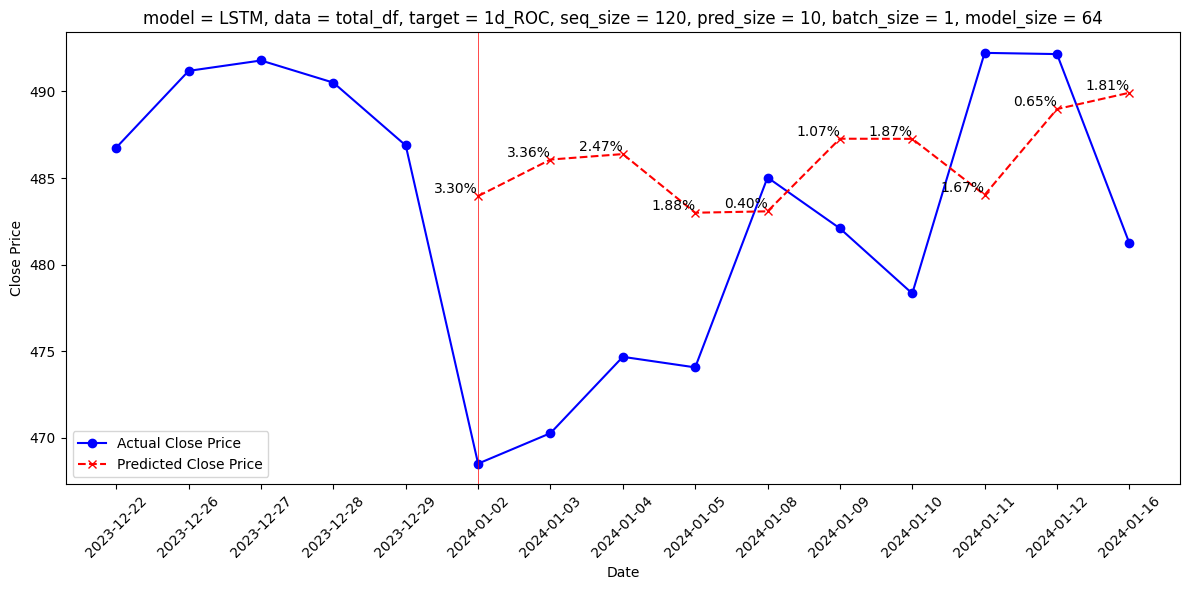

Average Error Rate: 1.85%


<Figure size 640x480 with 0 Axes>

In [9]:
# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d5_stock = stock_df.loc[d5_period,'Close'].to_list()
d10_period = ['2023-12-15','2023-12-18','2023-12-19','2023-12-20','2023-12-21','2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d30_period = ['2023-11-16', '2023-11-17', '2023-11-20', '2023-11-21',
               '2023-11-22', '2023-11-24', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30', '2023-12-01', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14',
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29']
d10_stock = stock_df.loc[d10_period,'Close'].to_list()
d30_stock = stock_df.loc[d30_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d5_period+period, d5_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)

# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

# 평균 오차율 텍스트 추가
plt.text(0.015, 0.15, f"Average Error Ratio: {average_error_rate:.2f}%", transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))
     
plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {dataname}, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}, trials = {N_TRIALS}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
### When Local
plt.savefig(f'../../plots/predicts/prediction_{filename}.png')

### When Kaggle
# plt.savefig(f'/kaggle/working/prediction_{filename}.png')plt.show()
plt.clf()

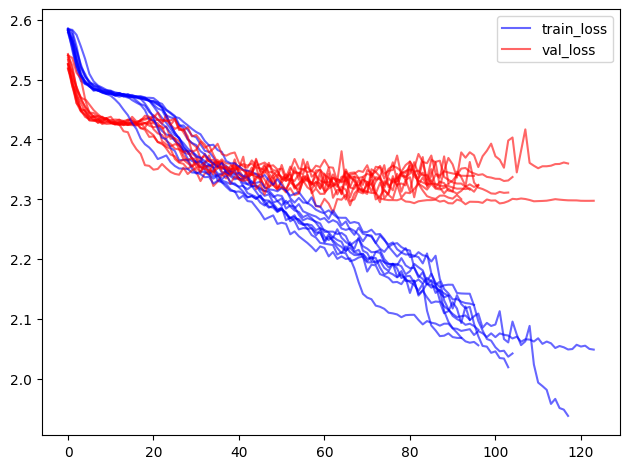

<Figure size 640x480 with 0 Axes>

In [10]:
### Visualize train-validation loss

for t in list(range(1,N_TRIALS+1)):
    plt.plot(range(len(globals()[f'train_losses_{t}'])),
             globals()[f'train_losses_{t}'],
             color='blue',alpha=0.6)
    plt.plot(range(len(globals()[f'val_losses_{t}'])),
             globals()[f'val_losses_{t}'],
             color='red',alpha=0.6)
plt.legend(['train_loss','val_loss'])
plt.tight_layout()
### When Local
plt.savefig(f'../../plots/train_val_loss/{N_TRIALS}trials_train_val_loss_{filename}.png')

### When Kaggle
# plt.savefig(f'/kaggle/working/{N_TRIALS}trials_train_val_loss_{filename}.png')
plt.show()
plt.clf()